# Clustering VoC

Date: 2025/5/7

Reference: https://cookbook.openai.com/examples/clustering

## Dataset (CC0 license)

DATASET: Digital Voice-of-Customer on sharing mobility services

https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/JXK3Z8

Publication: MOBI-Qual: a common framework to manage the product-service system quality of shared mobility

https://link.springer.com/article/10.1007/s10696-023-09520-y

In [1]:
DATA_PATH = "dataset/Digital VoC Dataset.xlsx"

In [2]:
import pandas as pd

df = pd.read_excel(DATA_PATH)
df.head()

,ID,Fonte,Country,Provider,Type,Data,Rating,Review
0,1,Yelp!,UNITED STATES,Zipcar,Station based,38749,5,Did you know you can make a zipcar reservation...
1,2,Yelp!,UNITED STATES,Zipcar,Station based,38749,5,I've been meaning to write up Zipcar for a whi...
2,3,Yelp!,UNITED STATES,Zipcar,Station based,38749,4,EDIT 2/21: After a slightly messy first Zipcar...
3,4,Yelp!,UNITED STATES,Zipcar,Station based,38749,5,I love Zipcar I have be a pround member sinc...
4,5,Yelp!,UNITED STATES,Zipcar,Station based,38777,5,Flexcar is the answer for those of us that are...


In [3]:
len(df)

11127

In [4]:
# "Fonte" in Italian means "Source" in English.

df = df.rename(columns={"Fonte": "Source"})
df.head()

,ID,Source,Country,Provider,Type,Data,Rating,Review
0,1,Yelp!,UNITED STATES,Zipcar,Station based,38749,5,Did you know you can make a zipcar reservation...
1,2,Yelp!,UNITED STATES,Zipcar,Station based,38749,5,I've been meaning to write up Zipcar for a whi...
2,3,Yelp!,UNITED STATES,Zipcar,Station based,38749,4,EDIT 2/21: After a slightly messy first Zipcar...
3,4,Yelp!,UNITED STATES,Zipcar,Station based,38749,5,I love Zipcar I have be a pround member sinc...
4,5,Yelp!,UNITED STATES,Zipcar,Station based,38777,5,Flexcar is the answer for those of us that are...


In [5]:
df.Provider.unique()

array(['Zipcar', 'Enterprice Car Share', 'Car2go', 'piccolo',
       'GoGet CarShare', 'DriveNow', 'Hertz 24', 'Evo Car Share',
       'Ubeeqo', 'Maven'], dtype=object)

In [6]:
df.Type.unique()

array(['Station based', 'Free floating', 'Mixed'], dtype=object)

In [7]:
df.Country.unique()

array(['UNITED STATES ', 'CANADA', 'AUSTRALIA', 'Non specificata ', 'UK'],
      dtype=object)

In [8]:
df.Source.unique()

array(['Yelp!', 'Playstore', 'Google', 'Trustpilot.com', 'Facebook'],
      dtype=object)

In [9]:
df.groupby("Provider").Provider.count()

Provider
Car2go                  3003
DriveNow                 599
Enterprice Car Share     547
Evo Car Share            585
GoGet CarShare           252
Hertz 24                 151
Maven                    313
Ubeeqo                   154
Zipcar                  5259
piccolo                  264
Name: Provider, dtype: int64

In [10]:
df.Review[0]

"Did you know you can make a zipcar reservation from your cell?? And you can extend your reservation in about 4 seconds from your cell as well     this was HUGH when the line at TraderJoe's was more hellish than expected  Love zipcar _x000D_\n_x000D_\nAnyone know what happens if you have the car out longer than your allotted reservation time? -- Update: I've heard from a few people that the alleged $50 late fine is legit  \xa0Guess I'll always be bringing my car back on time!"

In [11]:
# Replace these special characters with ' '
replace_patterns = [['\n', ' '], ['\xa0', ' '],['_x000D_', ' ']]

def replace_(x):
    for r in replace_patterns:
        x = x.replace(*r)
    return x

print(replace_(df.Review[2]))

EDIT 2/21: After a slightly messy first Zipcar experience   Pam from Zipcar was extremely helpful and immediately responded to my concerns   They get an extra star for excellent customer service and hopefully I'll be adding back that last star after my next trip!      2/20 - On Sunday we decided to take our first mini trip since selling our car   When we got to the car location   the car we'd reserved was lost (someone from Zipcar was there looking for it)   He'd driven another Zipcar so he let us take that while he went to look for the other car   It did take a good 15 minutes to get everything sorted out though and the credit we were told we'd get was not added to our account   We'd also planned on extending the car we requested if need be (it was open according to the internet about five minutes before we left home)   but the car we were given was not open so we were unable to extend the reservation when I called   Last   were given no instructions about what to do with the car we'd

In [12]:
df.Review = df.Review.apply(replace_)
df.Review.head()

0    Did you know you can make a zipcar reservation...
1    I've been meaning to write up Zipcar for a whi...
2    EDIT 2/21: After a slightly messy first Zipcar...
3    I love Zipcar   I have be a pround member sinc...
4    Flexcar is the answer for those of us that are...
Name: Review, dtype: object

## Calculating embeddings

In [13]:
from openai import OpenAI

MODEL = "text-embedding-3-small"

client = OpenAI()

In [14]:
texts = df.Review[0:2]
texts

0    Did you know you can make a zipcar reservation...
1    I've been meaning to write up Zipcar for a whi...
Name: Review, dtype: object

In [15]:
def calc_embeddings(texts):
    response = client.embeddings.create(input=texts, model=MODEL)
    return [data.embedding for data in response.data]

In [16]:
##########################
RUN_CALC_EMBEDDINGS = True
##########################

import pickle

N_BATCH = 30
N_SAMPLES = 900

embeddings = []

if RUN_CALC_EMBEDDINGS:
    samples = df.sample(N_SAMPLES)
    print(f"0/{len(samples)}", end=" ")
    
    for n in range(0, len(samples), N_BATCH):
        texts = samples.Review[n:n+N_BATCH]
        embeddings.extend(calc_embeddings(texts))
        print(f"{n+N_BATCH}/{len(samples)}", end=" ")
    
    with open('pickle_data/embeddings.pkl', 'wb') as f:
        pickle.dump({"samples": samples, "embeddings": embeddings}, f)

    df = samples

else:
    with open('pickle_data/embeddings.pkl', 'rb') as f:
        pickle_data = pickle.load(f)
        df = pickle_data["samples"]
        embeddings = pickle_data["embeddings"]

0/900 30/900 60/900 90/900 120/900 150/900 180/900 210/900 240/900 270/900 300/900 330/900 360/900 390/900 420/900 450/900 480/900 510/900 540/900 570/900 600/900 630/900 660/900 690/900 720/900 750/900 780/900 810/900 840/900 870/900 900/900 

In [17]:
df.head()

,ID,Source,Country,Provider,Type,Data,Rating,Review
6226,6229,Playstore,Non specificata,Hertz 24,Station based,43466,1,Hertz customer services is terrible you can't...
1791,1792,Playstore,Non specificata,DriveNow,Free floating,42826,1,Didn't believe the 1 star reviews Installed a...
1084,1085,Yelp!,UNITED STATES,Zipcar,Station based,42309,5,Really good customer service I used a car for...
4343,4345,Playstore,Non specificata,Zipcar,Station based,43678,4,Generally smooth app but when your gasoline cr...
4034,4036,Trustpilot.com,UK,Car2go,Free floating,43313,2,After a few weeks of using car2go every now an...


In [18]:
df.Country.values[:3]

array(['Non specificata ', 'Non specificata ', 'UNITED STATES '],
      dtype=object)

In [19]:
# Narrow down to Station based and US and Zipcar

df.Country = df.Country.apply(lambda x: x.strip())

df["Embedding"] = embeddings
df = df[(df["Type"] == "Station based") & (df["Country"] == "UNITED STATES") & (df["Provider"] == "Zipcar")]
df.head()

,ID,Source,Country,Provider,Type,Data,Rating,Review,Embedding
1084,1085,Yelp!,UNITED STATES,Zipcar,Station based,42309,5,Really good customer service I used a car for...,"[-0.011090480722486973, -0.019939465448260307,..."
765,766,Google,UNITED STATES,Zipcar,Station based,41944,1,"Do not join""is my suggestion I use zipcar for...","[-0.007491136435419321, -0.017821019515395164,..."
4541,4543,Yelp!,UNITED STATES,Zipcar,Station based,39417,5,I read all the great reviews on yelp so I've d...,"[-0.019395850598812103, 0.017157360911369324, ..."
6249,6252,Yelp!,UNITED STATES,Zipcar,Station based,39630,5,After giving up my car nearly 4 years ago afte...,"[0.02326906844973564, -0.0023030994925647974, ..."
10251,10255,Yelp!,UNITED STATES,Zipcar,Station based,39692,2,This is now for ZipCar I do not like this co...,"[-0.00840537715703249, -0.016769245266914368, ..."


## K-means method

In [20]:
import numpy as np

matrix = np.vstack(df["Embedding"].values)
matrix.shape

(164, 1536)

### Find the clusters using K-means

In [21]:
from sklearn.cluster import KMeans

n_clusters = 4

kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
kmeans.fit(matrix)
labels = kmeans.labels_
df["Cluster"] = labels

df.groupby("Cluster").Rating.mean().sort_values()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/var/folders/_t/6t6dcyn14zb6p4jvvrgprd0m0000gn/T/ipykernel_73558/1919122863.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Cluster"] = labels


Cluster
3    1.031250
0    1.239130
2    2.585366
1    4.800000
Name: Rating, dtype: float64

Text(0.5, 1.0, 'Clusters identified visualized in language 2d using t-SNE')

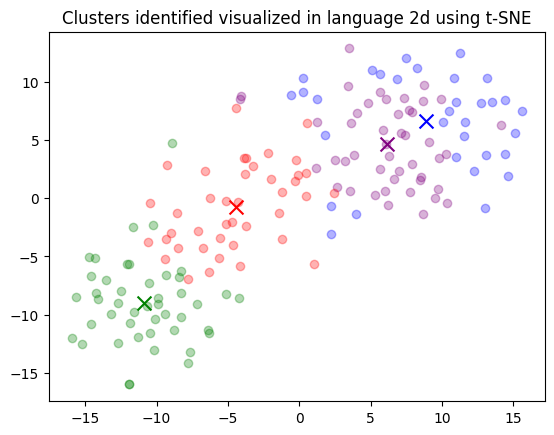

In [22]:
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200)
vis_dims2 = tsne.fit_transform(matrix)

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

for category, color in enumerate(["purple", "green", "red", "blue"]):
    xs = np.array(x)[df.Cluster == category]
    ys = np.array(y)[df.Cluster == category]
    plt.scatter(xs, ys, color=color, alpha=0.3)

    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, marker="x", color=color, s=100)
plt.title("Clusters identified visualized in language 2d using t-SNE")

### Text samples in the clusters & naming the clusters

In [23]:
df.head()

,ID,Source,Country,Provider,Type,Data,Rating,Review,Embedding,Cluster
1084,1085,Yelp!,UNITED STATES,Zipcar,Station based,42309,5,Really good customer service I used a car for...,"[-0.011090480722486973, -0.019939465448260307,...",1
765,766,Google,UNITED STATES,Zipcar,Station based,41944,1,"Do not join""is my suggestion I use zipcar for...","[-0.007491136435419321, -0.017821019515395164,...",0
4541,4543,Yelp!,UNITED STATES,Zipcar,Station based,39417,5,I read all the great reviews on yelp so I've d...,"[-0.019395850598812103, 0.017157360911369324, ...",1
6249,6252,Yelp!,UNITED STATES,Zipcar,Station based,39630,5,After giving up my car nearly 4 years ago afte...,"[0.02326906844973564, -0.0023030994925647974, ...",1
10251,10255,Yelp!,UNITED STATES,Zipcar,Station based,39692,2,This is now for ZipCar I do not like this co...,"[-0.00840537715703249, -0.016769245266914368, ...",2


In [24]:
from openai import OpenAI
import os

client = OpenAI()

# Reading a review which belong to each group.
rev_per_cluster = 3

for i in range(n_clusters):
    print(f"Cluster {i} Theme:", end=" ")

    reviews = "\n".join(
        df[df.Cluster == i].Review.sample(rev_per_cluster, random_state=42).values
    )

    messages = [
        {"role": "user", "content": f'What do the following customer reviews have in common?\n\nCustomer reviews:\n"""\n{reviews}\n"""\n\nTheme:'}
    ]

    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=messages,
        temperature=0,
        max_tokens=64,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0)
    print(response.choices[0].message.content.replace("\n", ""))

    print("---\n")
    
    sample_cluster_rows = df[df.Cluster == i].sample(rev_per_cluster, random_state=42)
    for j in range(rev_per_cluster):
        print(sample_cluster_rows.Rating.values[j], end=", ")
        print(sample_cluster_rows.Review.values[j], end="\n\n")

    print("-" * 100)

Cluster 0 Theme: The common theme in the customer reviews is **frustration with customer service and operational issues** related to Zipcar. 1. **Lack of Communication and Support**: Customers express dissatisfaction with the difficulty in reaching customer service and the long hold times. They feel that their concerns are not adequately addressed, leading to
---

1, I applied a zipcar yearly member at 2016 july  it has been more than 30 days since I paid the member fee online   but I never get my zipcar card   which means I cannot use their service  I called them two weeks ago   the customer service told me they will send me a card once again   and I still didn't get it  so I called them once again today   I told the customer service I cannot use their service   so I want to cancel my membership and get refund  the customer service ask me some account information   and after that   she told me she cancellde my account but she will not give me any refund   because I used their service?